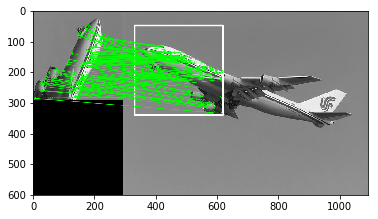

(<matplotlib.image.AxesImage at 0x25d89976f98>, None)

In [2]:
#coding:utf-8
#Flann单应性匹配

import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

# 读入图像
img1 = cv2.imread('datas/plane_part.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('datas/plane.jpg', cv2.IMREAD_GRAYSCALE)

# 创建sift对象
sift = cv2.xfeatures2d.SIFT_create()
# 查询特征点和描述符
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 0
# 创建字典参数
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)  # 处理索引
searchParams = dict(checks=50)  # 创建对象,用来指定索引树的遍历次数

flann = cv2.FlannBasedMatcher(indexParams, searchParams)

matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # 在原始图像和训练图像中查询特征点
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # 单应性
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # 对第二张图片计算相对于原始图像的投影畸变,并绘制边框
    h, w = img1.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
else:
    print("Not enough matches are found -%d/%d" % (len(good), MIN_MATCH_COUNT))
    matchesMask = None

# 显示图像
draw_params = dict(matchColor=(0, 255, 0),  # 绿线
                   singlePointColor=None,
                   matchesMask=matchesMask,
                   flags=2)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
plt.imshow(img3, 'gray'), plt.show()

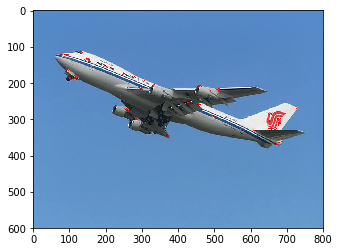

In [4]:
#检测图像的角点
# 转换颜色空间
img = cv2.imread('datas/plane.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
# 检测图像角点
dst = cv2.cornerHarris(gray,
                       2,
                       23,  # sobel算子的中孔,3-31之间的奇数
                       0.04)
# 将检测到有角点标记为红色
img[dst > 0.01 * dst.max()] = [0, 0, 255]
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

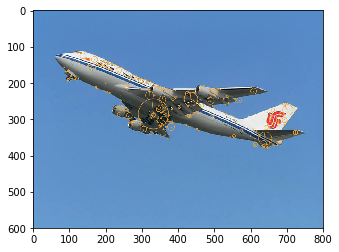

In [5]:
#sift特征
img = cv2.imread('datas/plane.jpg')
# 更换颜色空间
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 创建sift对象,计算灰度图像,会使用dog检测角点
sift = cv2.xfeatures2d.SIFT_create()
keypoints, descriptor = sift.detectAndCompute(gray, None)

# print(keypoints)
# 关键点有以下几个属性
# angle 表示特征的方向
# class_id 关键点的id
# octave 特征所在金字塔的等级
# pt 图像中关键点的坐标
# response 表示关键点的强度
# size  表示特征的直径
img = cv2.drawKeypoints(image=img,
                        outImage=img,
                        keypoints=keypoints,
                        color=(51, 163, 236),
                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

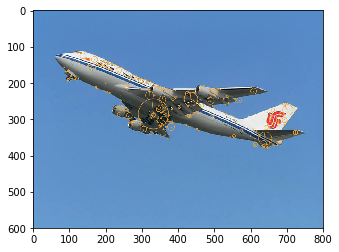

In [6]:
# sift用于检测斑点
img = cv2.imread('datas/plane.jpg')
# alg = 'SURF'
alg = 'SIFT'
# threshold = '8000'
# 阈值越小特征点越多
threshold = '4000'


def fd(algorithm):
    if algorithm == 'SIFT':
        return cv2.xfeatures2d.SIFT_create()
    if algorithm == 'SURF':
        # return cv2.xfeatures2d.SURF_create(float(threshold) if len(sys.argv) == 4 else 4000)
        return cv2.xfeatures2d.SURF_create(float(threshold))


# 更换颜色空间
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 创建sift对象,计算灰度图像,会使用dog检测角点
fd_alg = fd(alg)
keypoints, descriptor = fd_alg.detectAndCompute(gray, None)

# print(keypoints)
# 关键点有以下几个属性
# angle 表示特征的方向
# class_id 关键点的id
# octave 特征所在金字塔的等级
# pt 图像中关键点的坐标
# response 表示关键点的强度
# size  表示特征的直径
img = cv2.drawKeypoints(image=img,
                        outImage=img,
                        keypoints=keypoints,
                        color=(51, 163, 236),
                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

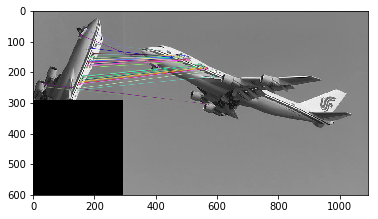

(<matplotlib.image.AxesImage at 0x25d89993c18>, None)

In [7]:
#ORB特征匹配
cv2.ocl.setUseOpenCL(False)
# 读入灰度图像
img1 = cv2.imread('datas/plane_part.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('datas/plane.jpg', cv2.IMREAD_GRAYSCALE)

# 创建orb特征检测器和描述符
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# 暴力匹配
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# 显示图像
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:40], img2, flags=2)
plt.imshow(img3)

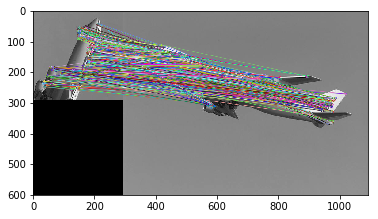

In [8]:
#k最邻近配匹
cv2.ocl.setUseOpenCL(False)
# 读入灰度图像
img1 = cv2.imread('datas/plane_part.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('datas/plane.jpg', cv2.IMREAD_GRAYSCALE)

# 创建orb特征检测器和描述符
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# knn匹配,返回k个匹配
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

# 显示图像
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, img2, flags=2)
plt.imshow(img3)

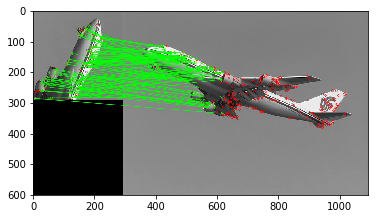

In [11]:
#Flann匹配法
#Fast library for approximate nearestneighbors  近似最近邻的快速库
# 读入图像
queryImage = cv2.imread('datas/plane_part.jpg', cv2.IMREAD_GRAYSCALE)
trainingImage = cv2.imread('datas/plane.jpg', cv2.IMREAD_GRAYSCALE)

# 创建sift对象
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(queryImage, None)
kp2, des2 = sift.detectAndCompute(trainingImage, None)

FLANN_INDEX_KDTREE = 0
# 创建字典参数
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)  # 处理索引
searchParams = dict(checks=50)  # 创建对象,用来指定索引树的遍历次数

flann = cv2.FlannBasedMatcher(indexParams, searchParams)

matches = flann.knnMatch(des1, des2, k=2)

matchesMask = [[0, 0] for i in range(len(matches))]

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]
drawParams = dict(matchColor=(0, 255, 0),
                  singlePointColor=(255, 0, 0),
                  matchesMask=matchesMask,
                  flags=0)

resultImage = cv2.drawMatchesKnn(queryImage, kp1, trainingImage, kp2, matches, None, **drawParams)
plt.imshow(resultImage)

In [ ]:
#基于纹身取证的应用程序示例
# 创建描述符
def create_descriptors(folder):
    files = []
    for (dirpath, dirnames, filenames) in walk(folder):
        files.extend(filenames)
    for f in files:
        save_descriptor(folder, f, cv2.xfeatures2d.SIFT_create())


# 保存描述符
def save_descriptor(folder, image_path, feature_detector):
    print("reading %s" % image_path)
    if image_path.endswith("npy") or image_path.endswith("avi"):
        return
    img = cv2.imread(join(folder, image_path), cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = feature_detector.detectAndCompute(img, None)
    descriptor_file = image_path.replace("jpg", "npy")
    np.save(join(folder, descriptor_file), descriptors)
    
# create_descriptors(dir)
#B 扫描匹配

In [ ]:
folder = argv[1]
query = cv2.imread(join(folder, 'part.jpg'), cv2.IMREAD_GRAYSCALE)

# 创建全局的文件,图片,描述符
files = []
images = []
descriptors = []
for (dirpath, dirnames, filenames) in walk(folder):
    files.extend(filenames)
    for f in files:
        if f.endswith('npy') and f != 'part.npy':
            descriptors.append(f)
    print(descriptors)

# 创建sift检测器
sift = cv2.xfeatures2d.SIFT_create()
query_kp, query_ds = sift.detectAndCompute(query, None)

# 创建flann匹配
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# 最小匹配数
MIN_MATCH_COUNT = 10

potential_culprits = {}
print(">> Initiating picture scan...")
for d in descriptors:
    print("--------- analyzing %s for matches ------------" % d)
    matches = flann.knnMatch(query_ds, np.load(join(folder, d)), k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)
    if len(good) > MIN_MATCH_COUNT:
        print('%s is a match! (%d)' % (d, len(good)))
    else:
        print('%s is not a match ' % d)
    potential_culprits[d] = len(good)

max_matches = None
potential_suspect = None
for culprit, matches in potential_culprits.items():
    if max_matches == None or matches > max_matches:
        max_matches = matches
        potential_suspect = culprit
print("potential suspect is %s" % potential_suspect.replace("npy", "").upper())